<a href="https://colab.research.google.com/github/rawat999/tensorflow-coursera/blob/master/coursera_3311_text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.5.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ITJ3L/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ITJ3L/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ITJ3L/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Classifier using GRU layer

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-05),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
782/782 [==============================] - 22s 23ms/step - loss: 0.6928 - accuracy: 0.5126 - val_loss: 0.6928 - val_accuracy: 0.5120
Epoch 2/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6921 - accuracy: 0.5364 - val_loss: 0.6921 - val_accuracy: 0.5238
Epoch 3/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6909 - accuracy: 0.5611 - val_loss: 0.6908 - val_accuracy: 0.5384
Epoch 4/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6880 - accuracy: 0.5922 - val_loss: 0.6855 - val_accuracy: 0.5680
Epoch 5/20
782/782 [==============================] - 18s 23ms/step - loss: 0.6137 - accuracy: 0.6943 - val_loss: 0.5254 - val_accuracy: 0.7678
Epoch 6/20
782/782 [==============================] - 18s 23ms/step - loss: 0.4666 - accuracy: 0.7898 - val_loss: 0.4423 - val_accuracy: 0.7956
Epoch 7/20
782/782 [==============================] - 18s 23ms/step - loss: 0.4049 - accuracy: 0.8245 - val_loss: 0.4207 - val_accuracy:

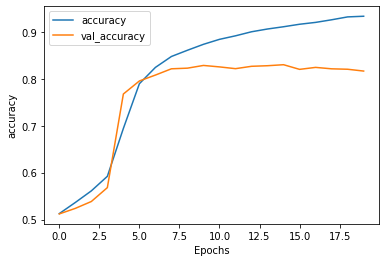

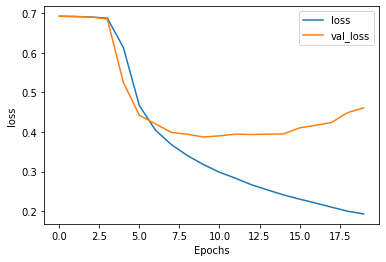

In [11]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Classifier using LSTM

In [12]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-05),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
782/782 [==============================] - 20s 22ms/step - loss: 0.6930 - accuracy: 0.5158 - val_loss: 0.6928 - val_accuracy: 0.5602
Epoch 2/20
782/782 [==============================] - 15s 20ms/step - loss: 0.6791 - accuracy: 0.6086 - val_loss: 0.6306 - val_accuracy: 0.6720
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 0.5474 - accuracy: 0.7418 - val_loss: 0.5366 - val_accuracy: 0.7418
Epoch 4/20
782/782 [==============================] - 16s 21ms/step - loss: 0.4732 - accuracy: 0.7934 - val_loss: 0.4986 - val_accuracy: 0.7672
Epoch 5/20
782/782 [==============================] - 16s 20ms/step - loss: 0.4243 - accuracy: 0.8246 - val_loss: 0.4783 - val_accuracy: 0.7762
Epoch 6/20
782/782 [==============================] - 16s 21ms/step - loss: 0.3888 - accuracy: 0.8420 - val_loss: 0.4763 - val_accuracy: 0.7773
Epoch 7/20
782/782 [==============================] - 16s 21ms/step - loss: 0.3608 - accuracy: 0.8572 - val_loss: 0.4731 - val_accuracy:

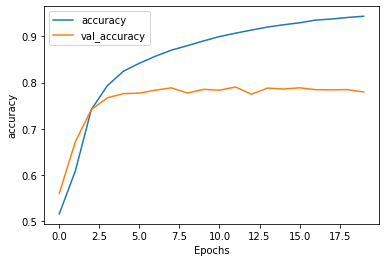

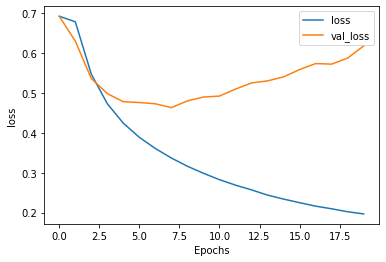

In [14]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Classifier using Convolution Layer

In [15]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-05),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
782/782 [==============================] - 34s 10ms/step - loss: 0.6929 - accuracy: 0.5078 - val_loss: 0.6923 - val_accuracy: 0.5240
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6879 - accuracy: 0.6082 - val_loss: 0.6788 - val_accuracy: 0.7171
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6609 - accuracy: 0.7317 - val_loss: 0.6426 - val_accuracy: 0.7467
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6153 - accuracy: 0.7638 - val_loss: 0.5930 - val_accuracy: 0.7724
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 0.5596 - accuracy: 0.7926 - val_loss: 0.5385 - val_accuracy: 0.7928
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5024 - accuracy: 0.8138 - val_loss: 0.4870 - val_accuracy: 0.8128
Epoch 7/20
782/782 [==============================] - 7s 9ms/step - loss: 0.4541 - accuracy: 0.8293 - val_loss: 0.4489 - val_accuracy: 0.8223
Epo

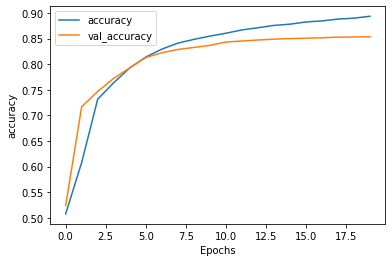

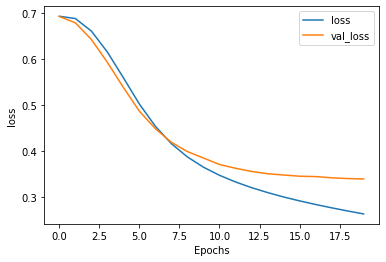

In [17]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')